In [505]:
def P1Relaxed(N,M,xms,xnv,fnmMin,Fm,tnmv,tnmr,cn,flag,NOl):
    # define sets:
    Nset =[i for i in range(1,N+1)] # set of vehicles
    Mset =[i for i in range(1,M+1)] # set of RDUs
    # solve the LP relaxation of P1 (i.e., P1.1)
    delay_mdl = Model("DelayModel")
    
    anm   = delay_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # assignment decision variable
    anmP  = delay_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # auxiliary decision variable
    tnm   = delay_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0) # delay decision variable
    TRT   = delay_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0) # ready time decision variable
    gamma = delay_mdl.addVar(vtype = GRB.CONTINUOUS, lb = 0)
    fnm   = delay_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0) # power allocation decision variable
    ovfnm = delay_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0) # auxiliary decision variable
    
    delay_mdl.modelSense = GRB.MINIMIZE
    delay_mdl.setObjective(gamma)
    delay_mdl.addConstrs(gamma >= tnm[n,m] for n in Nset for m in Mset) # the largest delay
    
    delay_mdl.addConstrs(quicksum(anm[n,m] for m in Mset) == 1 for n in Nset) # (7b)
    if len(NOl):
        for n in Nset:
            for m in Mset:
                if NOl[n] == m:
                    delay_mdl.addConstr(anm[n,m] == 0.8)
                else:
                    delay_mdl.addConstr(anm[n,m] <= 0.2)

    '''    
    else:
        for n in Nset:
            if flag[n] != 1:
                for m in Mset:
                    if xms[m] - xnv[n] <= 0:
                        delay_mdl.addConstr(anm[n,m] == 0) # (7c) # see the discussion end of page 2 left side.
            else:
                delay_mdl.addConstr(anm[n,1] == 1)
        
    '''
    delay_mdl.addConstrs(anm[n,m]*fnmMin[n,m] <= fnm[n,m] for n in Nset for m in Mset) # (7d-1)
    delay_mdl.addConstrs(anm[n,m]*Fm[m] >= fnm[n,m] for n in Nset for m in Mset) # (7d-2)
    for n in Nset:
        if n == 1:
            delay_mdl.addConstrs(anm[1,m]*tnmv[1,m] >= 0 for m in Mset) # (7e)
    
    
    
    # additional constraints to calculate the completion time of each offloaded task:
    for n in Nset: # (5) Ready time (point) TRT
        if n == 1:
            delay_mdl.addConstrs(TRT[1,m] >= anm[1,m]*(tnmv[1,m]+tnmr[1,m]) for m in Mset)
        else:
            delay_mdl.addConstrs(TRT[n,m] >= tnm[n-1,m] for m in Mset)
            delay_mdl.addConstrs(TRT[n,m] >= anm[n,m]*(tnmv[n,m]+tnmr[n,m]) for m in Mset)
     
    # Process time (point) tnm
    delay_mdl.addConstrs(tnm[n,m] == TRT[n,m] + anmP[n,m]*cn[n]*ovfnm[n,m] for n in Nset for m in Mset)
    
    # auxiliary constraint to avoid dividing by decision variable fnm
    delay_mdl.addConstrs(ovfnm[n,m]*(0.01+fnm[n,m]) == 1 for n in Nset for m in Mset)
    # auxiliary constraint to avoid multiplying three decision variables
    delay_mdl.addConstrs(anm[n,m]*anm[n,m] == anmP[n,m] for n in Nset for m in Mset)
    
    delay_mdl.Params.TimeLimit = 20;
    delay_mdl.Params.LogToConsole = 0
    delay_mdl.Params.OutputFlag = 0
    delay_mdl.params.NonConvex = 2
    delay_mdl.optimize()
    optimalAssignment = {}
    for n in Nset:
        dummyList = []
        for m in Mset:
            dummyList.append(anm[n,m].x)
        optimalAssignment[n] = dummyList.index(max(dummyList)) + 1 
        
    maxDelay = delay_mdl.objval
    return optimalAssignment, maxDelay

def P2(N,M,xms,xnv,fnmMin,Fm,tnmv,tnmr,cn,tMAX,alpha,beta,P,kappa,flag,NOl,usedAlgo):
    # define sets:
    Nset =[i for i in range(1,N+1)] # set of vehicles
    Mset =[i for i in range(1,M+1)] # set of RDUs
    power_mdl = Model("PowerModel")
    if usedAlgo == 1:
        anm   = power_mdl.addVars(Nset,Mset, vtype = GRB.BINARY, lb = 0, ub = 1) # assignment decision variable
    else:
        anm   = power_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # assignment decision variable
    anmP  = power_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0, ub = 1) # auxiliary decision variable
    tnm   = power_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0) # delay decision variable
    TRT   = power_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0) # ready time decision variable
    gamma = power_mdl.addVar(vtype = GRB.CONTINUOUS, lb = 0)
    fnm   = power_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0) # power allocation decision variable
    ovfnm = power_mdl.addVars(Nset,Mset, vtype = GRB.CONTINUOUS, lb = 0) # auxiliary decision variable
    
    Er = power_mdl.addVar(vtype = GRB.CONTINUOUS, lb = 0) # auxiliary decision variable
    Ec = power_mdl.addVar(vtype = GRB.CONTINUOUS, lb = 0) # auxiliary decision variable
    
    power_mdl.modelSense = GRB.MINIMIZE
    power_mdl.setObjective(alpha*Er+beta*Ec)
    power_mdl.addConstr(Er == quicksum(anm[n,m]*tnmr[n,m]*P for m in Mset for n in Nset))
    power_mdl.addConstr(Ec == quicksum(kappa*cn[n]*fnm[n,m]*fnm[n,m] for m in Mset for n in Nset))
    
    power_mdl.addConstrs(tMAX >= tnm[n,m] for n in Nset for m in Mset) # fix using (14)
    
    power_mdl.addConstrs(quicksum(anm[n,m] for m in Mset) == 1 for n in Nset) # (7b)
    
    if len(NOl):
        for n in Nset:
            for m in Mset:
                if NOl[n] == m:
                    power_mdl.addConstr(anm[n,1] <= 1)
                else:
                    power_mdl.addConstr(anm[n,m] <= 0.1)

    else:
        for n in Nset:
            if flag[n] != 1:
                for m in Mset:
                    if xms[m] - xnv[n] <= 0:
                        power_mdl.addConstr(anm[n,m] <= 0.2) # (7c) # see the discussion end of page 2 left side.
            else:
                power_mdl.addConstr(anm[n,1] <= 1.0)
    
    power_mdl.addConstrs(anm[n,m]*fnmMin[n,m] <= fnm[n,m] for n in Nset for m in Mset) # (7d-1)
    #power_mdl.addConstrs(anm[n,m]*Fm[m] >= fnm[n,m] for n in Nset for m in Mset) # (7d-2)

    for n in Nset:
        if n == 1:
            power_mdl.addConstrs(anm[1,m]*tnmv[1,m] >= 0 for m in Mset) # (7e)
    
    # additional constraints to calculate the completion time of each offloaded task:
    
    for n in Nset: # (5) Ready time (point) TRT
        if n == 1:
            power_mdl.addConstrs(TRT[1,m] >= anm[1,m]*(tnmv[1,m]+tnmr[1,m]) for m in Mset)
        else:
            power_mdl.addConstrs(TRT[n,m] >= tnm[n-1,m] for m in Mset)
            power_mdl.addConstrs(TRT[n,m] >= anm[n,m]*(tnmv[n,m]+tnmr[n,m]) for m in Mset)
     
    # Process time (point) tnm
    power_mdl.addConstrs(tnm[n,m] == TRT[n,m] + anmP[n,m]*cn[n]*ovfnm[n,m] for n in Nset for m in Mset)
    # auxiliary constraint to avoid dividing by decision variable fnm
    power_mdl.addConstrs(ovfnm[n,m]*fnm[n,m] == 1 for n in Nset for m in Mset)
    # auxiliary constraint to avoid multiplying three decision variables
    power_mdl.addConstrs(anm[n,m]*anm[n,m] == anmP[n,m] for n in Nset for m in Mset)
    
    power_mdl.Params.TimeLimit = 50;
    power_mdl.Params.LogToConsole = 0
    power_mdl.Params.OutputFlag = 0
    power_mdl.params.NonConvex = 2
    power_mdl.optimize()
    objValue = 999999
    if power_mdl.Status == GRB.OPTIMAL:
        print('Optimal objective: %g' % power_mdl.ObjVal)
        objval = power_mdl.objval
        objValue = alpha*Er.x+beta*Ec.x
        condition = False
    elif power_mdl.Status == GRB.INF_OR_UNBD:
        print('Model is infeasible or unbounded')
        condition = True
    elif power_mdl.Status == GRB.INFEASIBLE:
        print('Model is infeasible')
        condition = True
    elif power_mdl.Status == GRB.UNBOUNDED:
        print('Model is unbounded')
        condition = True
    else:
        print('Optimization ended with status %d' % power_mdl.Status)
        print(power_mdl.MIPGap)
        if power_mdl.MIPGap > 99999:
            condition = True
        else:
            objValue = alpha*Er.x+beta*Ec.x
            condition = False

     
    return condition, objValue

In [512]:
# the following code implements Optimal-Delay-Guaranteed Energy Efficient
# Cooperative Offloading in VEC Networks research paper by Yao Zhu et al. 
import random
import math
from gurobipy import*
import gurobipy as gp


M = 5 # number of RSU

LR = 100 # road length in meters
Lm = LR/M # Length of road segement
B = 1 # band width 
P = 100 # transmission power 
N0 = 10**-10 # noise power
alpha = 1
beta = 1
kappa = 10**-11 # hardware parameter for computational consumption 

xms = {} # position of RDU m
for i in range(1,M+1):
    xms[i] = LR - i*Lm + Lm/2
finalResultsPowerAlgo = []
finalResultsPowerNOl = []
finalResultsPowerTwoStep = []

finalResultsDelayAlgo = []
finalResultsDelayNOl = []
for N in range(3,15): # the number of vehicles 3, 4, ..., 14
    avPowerAlgo = []
    avPowerTwoStep = []
    avPowerNOAl = []


    avDelAlgo = []
    avDelNOAl = []
    
    for expID in range(5): # specify how many replicates for each setup, I recommend at least 20 due to the large randomness in the system
        xveh = [random.uniform(0, 100) for _ in range(N)]  # Generate locations of vehicles on the road
        xveh = sorted(xveh)
        xnv = {}
        for i in range(1,N+1):
            xnv[i] = xveh[i-1]
            
        hnm = {} # THIS VALUE IS ESTIMATED, WE NEED AN EQUATION TO CALCULATE THIS VALUE FOR EACH VEHICLE FOR EACH SERVER!!!
        for n in range(1,N+1):
            for m in range(1,M+1):
                hnm[n,m] = 10*max((-xms[m] + Lm/2 + xnv[n])/v,(xms[m] - Lm/2 - xnv[n])/v)

        Fm = {i+1: random.randint(5, 10) for i in range(M)} # max computational capacity of server m
        v = 120*1000/3600 # velocity in m/s

        cn = {i+1: random.uniform(0.5, 1.5) for i in range(N)} # required computational resource
        dn = {i+1: random.randint(100, 300) for i in range(N)} # task size 


        tnmv = {} # driving delay
        tnmr = {} # transmission delay/cost
        for n in range(1,N+1):
            for m in range(1,M+1):
                tnmv[n,m] = max(0,(xms[m] - Lm/2 - xnv[n])/v)
                tnmr[n,m] = dn[n]/B/math.log(1+P*hnm[n,m]/N0,2)
        fnmMin = {} # the minimal frequency
        for n in range(1,N+1):
            for m in range(1,M+1):
                fnmMin[n,m] = max(cn[n]*v/Lm,(cn[n]*v)/(xms[m]+Lm/2-xnv[n]))/10


        flag = {} # dictionary to save the assignment of last vehicles leaving 
        for n in range(1,N+1):
            counter = 0
            for m in range(1,M+1):
                if xms[m] - xnv[n] <= 0:
                    counter += 1
            if counter == M:
                flag[n] = 1
            else:
                flag[n] = 0

        # solve the model twice, once using Algorithm 1, then using the Nearest Offloading
        NOl = {}
        optimalAssignment, delayVal = P1Relaxed(N,M,xms,xnv,fnmMin,Fm,tnmv,tnmr,cn,flag,NOl)
        print('Delay value Algo', delayVal)
        solverStatus = True
        while(solverStatus):
            solverStatus, powerConsumption = P2(N,M,xms,xnv,fnmMin,Fm,tnmv,tnmr,cn,delayVal,alpha,beta,P,kappa,flag,NOl,0)
            delayVal = 1.05*delayVal
        solverStatus, twoStepVal = P2(N,M,xms,xnv,fnmMin,Fm,tnmv,tnmr,cn,99999,alpha,beta,P,kappa,flag,{},0)
        print('Implement the NO')    
        NOl = {}
        for n in range(1,N+1):
            dummyList = []
            for m in range(1,M+1):
                if xms[m] >= xnv[n]:
                    dummyList.append(xms[m] - xnv[n])
                else:
                    dummyList.append(999999)
            val = min(dummyList)
            if val < 999:
                NOl[n] = dummyList.index(val) + 1
            else:
                NOl[n] = M
        NearestAssignment, NearestdelayVal = P1Relaxed(N,M,xms,xnv,fnmMin,Fm,tnmv,tnmr,cn,flag,NOl)
        print('Delay value Nearest Offloading', NearestdelayVal)
        solverStatus = True
        counter = 0
        while(solverStatus and counter <= 10):
            counter += 1
            solverStatus, NearestpowerConsumption = P2(N,M,xms,xnv,fnmMin,Fm,tnmv,tnmr,cn,NearestdelayVal,alpha,beta,P,kappa,flag,NOl,0)
            NearestdelayVal = 1.05*NearestdelayVal
        avDelAlgo.append(delayVal)
        avPowerTwoStep.append(twoStepVal)
        avDelNOAl.append(NearestdelayVal)
        avPowerAlgo.append(powerConsumption)
        avPowerNOAl.append(NearestpowerConsumption)
    print('Average delay across generated instances Algo: ',sum(avDelAlgo)/len(avDelAlgo)) # populate AlgoDelay list using these values for specific value of N
    print('Average delay across generated instances NO: ',sum(avDelNOAl)/len(avDelNOAl)) # populate NODelay list using these values for specific value of N

    print('Average power consumption across generated instances Algo: ',sum(avPowerAlgo)/len(avPowerAlgo)) # populate AlgoDelay list using these values for specific value of N
    print('Average power consumption across generated instances NO: ',sum(avPowerNOAl)/len(avPowerNOAl)) # populate NODelay list using these values for specific value of N
    
    finalResultsPowerAlgo.append(sum(avPowerAlgo)/len(avPowerAlgo))
    finalResultsPowerNOl.append(sum(avPowerNOAl)/len(avPowerNOAl))
    finalResultsPowerTwoStep.append(sum(avPowerTwoStep)/len(avPowerTwoStep))

    finalResultsDelayAlgo.append(sum(avDelAlgo)/len(avDelAlgo))
    finalResultsDelayNOl.append(sum(avDelNOAl)/len(avDelNOAl))

Set parameter TimeLimit to value 20
Delay value Algo 1.5994338169463433
Set parameter TimeLimit to value 50
Optimal objective: 1632.93
Set parameter TimeLimit to value 50
Optimal objective: 1602.63
Implement the NO
Set parameter TimeLimit to value 20
Delay value Nearest Offloading 5.866836993241407
Set parameter TimeLimit to value 50
Optimal objective: 1663.12
Set parameter TimeLimit to value 20
Delay value Algo 1.3239347162413706
Set parameter TimeLimit to value 50
Model is infeasible
Set parameter TimeLimit to value 50
Optimal objective: 1172.61
Set parameter TimeLimit to value 50
Optimal objective: 1157.07
Implement the NO
Set parameter TimeLimit to value 20
Delay value Nearest Offloading 5.411382528352163
Set parameter TimeLimit to value 50
Optimal objective: 1199.07
Set parameter TimeLimit to value 20
Delay value Algo 1.4578638231302583
Set parameter TimeLimit to value 50
Optimal objective: 1196.62
Set parameter TimeLimit to value 50
Optimal objective: 1168.41
Implement the NO
Set

Optimal objective: 2720.33
Implement the NO
Set parameter TimeLimit to value 20
Delay value Nearest Offloading 5.707745317854597
Set parameter TimeLimit to value 50
Optimal objective: 2900.04
Average delay across generated instances Algo:  1.605850926208045
Average delay across generated instances NO:  6.138157042507741
Average power consumption across generated instances Algo:  2778.421997234091
Average power consumption across generated instances NO:  2882.9952403819634
Set parameter TimeLimit to value 20
Delay value Algo 1.539023107976569
Set parameter TimeLimit to value 50
Optimal objective: 3685.87
Set parameter TimeLimit to value 50
Optimal objective: 3654.94
Implement the NO
Set parameter TimeLimit to value 20
Delay value Nearest Offloading 5.909424447241438
Set parameter TimeLimit to value 50
Optimal objective: 3797.81
Set parameter TimeLimit to value 20
Delay value Algo 1.4325480685687626
Set parameter TimeLimit to value 50
Optimal objective: 3244.47
Set parameter TimeLimit to

Optimal objective: 4605.24
Set parameter TimeLimit to value 20
Delay value Algo 1.5158524154381947
Set parameter TimeLimit to value 50
Optimal objective: 4462.19
Set parameter TimeLimit to value 50
Optimal objective: 4391.46
Implement the NO
Set parameter TimeLimit to value 20
Delay value Nearest Offloading 5.600200806428718
Set parameter TimeLimit to value 50
Optimal objective: 4587.58
Average delay across generated instances Algo:  1.668300841786739
Average delay across generated instances NO:  6.2043701776353934
Average power consumption across generated instances Algo:  4674.716935923438
Average power consumption across generated instances NO:  4820.551707237306
Set parameter TimeLimit to value 20
Delay value Algo 1.863312864770815
Set parameter TimeLimit to value 50
Optimal objective: 5086.68
Set parameter TimeLimit to value 50
Optimal objective: 5005.86
Implement the NO
Set parameter TimeLimit to value 20
Delay value Nearest Offloading 6.210176632640489
Set parameter TimeLimit to

Model is infeasible
Set parameter TimeLimit to value 50
Model is infeasible
Set parameter TimeLimit to value 50
Optimal objective: 6481.14
Set parameter TimeLimit to value 50
Optimal objective: 6352.4
Implement the NO
Set parameter TimeLimit to value 20
Delay value Nearest Offloading 8.17136603771862
Set parameter TimeLimit to value 50
Optimal objective: 6875.66
Set parameter TimeLimit to value 20
Delay value Algo 1.8511586561409552
Set parameter TimeLimit to value 50
Optimal objective: 6520.82
Set parameter TimeLimit to value 50
Optimal objective: 6443.75
Implement the NO
Set parameter TimeLimit to value 20
Delay value Nearest Offloading 6.677067081993094
Set parameter TimeLimit to value 50
Optimal objective: 6740.2
Average delay across generated instances Algo:  1.822788149558431
Average delay across generated instances NO:  6.732631360466419
Average power consumption across generated instances Algo:  6408.140852777334
Average power consumption across generated instances NO:  6656.90

In [502]:
solverStatus, powerConsumption = P2(N,M,xms,xnv,fnmMin,Fm,tnmv,tnmr,cn,5*delayVal,alpha,beta,P,kappa,flag,{})

Set parameter TimeLimit to value 50
Optimal objective: 6387.42


<Figure size 1080x648 with 0 Axes>

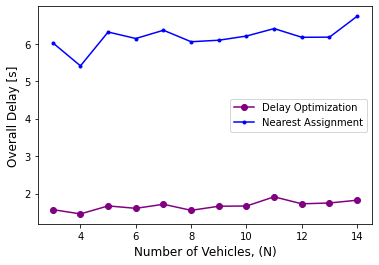

In [513]:
# save the results and plot them
import matplotlib.pyplot as plt

plt.figure(figsize=(15,9))
fig, ax = plt.subplots()


numVehicles = [3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13,   14]


plt.plot(numVehicles, finalResultsDelayAlgo,'o-', color='purple', label='Delay Optimization')
plt.plot(numVehicles, finalResultsDelayNOl,'.-', color = 'blue',label='Nearest Assignment')


plt.legend()
ax.set_xlabel('Number of Vehicles, (N)', fontsize = 12)
ax.set_ylabel('Overall Delay [s]', fontsize = 12)
  
plt.show()

<Figure size 1080x648 with 0 Axes>

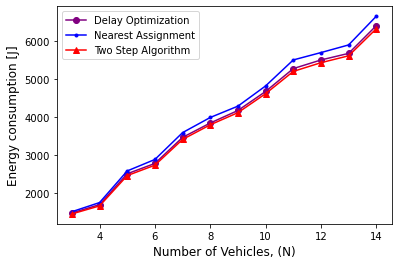

In [516]:
# Use saved results and plot them
import matplotlib.pyplot as plt

plt.figure(figsize=(15,9))
fig, ax = plt.subplots()


numVehicles = [3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13,   14]


plt.plot(numVehicles, finalResultsPowerAlgo,'o-', color='purple', label='Delay Optimization')
plt.plot(numVehicles, finalResultsPowerNOl,'.-', color = 'blue',label='Nearest Assignment')
plt.plot(numVehicles, finalResultsPowerTwoStep,'^-', color = 'red',label='Two Step Algorithm')


plt.legend()
ax.set_xlabel('Number of Vehicles, (N)', fontsize = 12)
ax.set_ylabel('Energy consumption [J]', fontsize = 12)
  
plt.show()

<Figure size 1080x648 with 0 Axes>

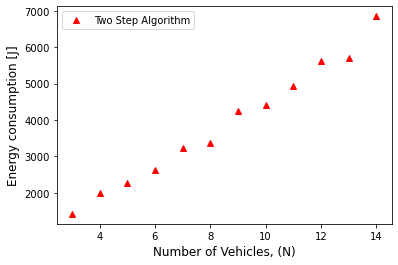

In [511]:
# Use saved results and plot them
import matplotlib.pyplot as plt

plt.figure(figsize=(15,9))
fig, ax = plt.subplots()


numVehicles = [3,    4,    5,    6,    7,    8,    9,    10,   11,   12,   13,   14]


plt.plot(numVehicles, finalResultsPowerTwoStep,'^', color = 'red',label='Two Step Algorithm')


plt.legend()
ax.set_xlabel('Number of Vehicles, (N)', fontsize = 12)
ax.set_ylabel('Energy consumption [J]', fontsize = 12)
  
plt.show()